This notebook is part of a series of notebooks that delve into the comprehensive analysis of order book events. Each notebook in this series focuses on various aspects of order book data, aiming to provide in-depth insights and understanding into the dynamics of financial markets. 

In [1]:
import datetime
import pandas as pd
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from functools import partial
from scipy.optimize import curve_fit
import scipy
import statsmodels.api as sm
# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
#load data
pair = "XCAD-USDT"
exchange = "GATEIO"

start = datetime.datetime(2022, 11, 1)
end = datetime.datetime(2022, 11, 4)

books = pd.read_parquet("/Users/miguelmeier/Jupiter_Notebook/ser_project/data/test/books_GATEIO_AVAX-USDT_2022-11-01.parquet")
trades = pd.read_parquet("/Users/miguelmeier/Jupiter_Notebook/ser_project/data/test/trades_GATEIO_AVAX-USDT_2022-11-01.parquet")
# Filter the DataFrame
#books = books[(books['received_time'] >= start) & (books['received_time'] <= end)]
#trades = trades[(trades['received_time'] >= start) & (trades['received_time'] <= end)]

## Market Microstructure

In [3]:
def smallest_increment(number):

    # Convert the number to a string and split by the decimal point
    parts = str(number).split('.')
    
    # If there's a decimal part
    if len(parts) > 1:
        # Count the number of digits after the decimal point
        decimal_places = len(parts[1])
        
        # Return the smallest increment based on the decimal places
        return 10 ** -decimal_places
    else:
        # If there's no decimal, the smallest increment is 1
        return 1

tick_size = smallest_increment(trades["price"].iloc[0])
books['mid'] = (books['bid_0_price'] + books['ask_0_price']) / 2

In [4]:
# delete trades inside of spread:
delete_fake = True

#percentage of trades within spread
def find_closest_timestamp(ts, ts_list):
    """Find the closest timestamp in ts_list to ts."""
    deltas = np.abs((ts_list - ts).total_seconds())
    return ts_list[np.argmin(deltas)]
    target = row.name + pd.Timedelta(seconds=5)
    return ts_index.get_loc(target, method='nearest')

tick_size = smallest_increment(trades["price"].iloc[0])
book1 = books.copy()
# Merge trades and l1 data
book1['future_bid'] = book1.bid_0_price.shift(-1)
book1['future_ask'] = book1.ask_0_price.shift(-1)
# book1['mid_future_5s'] = book1.mid.shift(-5)

df = pd.merge_asof(
	left = trades.rename(columns = {'received_time': 'trade_received_time'}),
	right = book1.rename(columns = {'received_time': 'depth_received_time'}),
	left_on = 'trade_received_time',
	right_on = 'depth_received_time',
	tolerance = pd.Timedelta(minutes = 60),
)
df = df.dropna().reset_index(drop = True)

# Detection logic
epsilon = tick_size
df['fake'] = (
	# Trade is fake when its inside spread (+- some epsilon, perhaps one tick)
	(df['price'] > df['bid_0_price'] + epsilon) & 
	(df['price'] < df['ask_0_price'] - epsilon) &
	# To prevent false positives, we also assume we didn't receive the next depth update yet
	(df['price'] > df['future_bid'] + epsilon) & 
	(df['price'] < df['future_ask'] - epsilon)
)

fake_volume = df.loc[df['fake'] == 1, 'quantity'].sum()
all_volume = df['quantity'].sum()

# Note that this method has some false positives, but still leads to better & cleaner data for most use cases
print('Fake trade percentage', df['fake'].mean() * 100)
print('Fake volume percentage', fake_volume / all_volume * 100)

trades = df[["side","quantity","price","trade_received_time", "origin_time_x", "fake", "trade_id"]]
trades["received_time"] =trades["trade_received_time"]

if delete_fake:
    print("drop fake trades!")
    trades = trades[~trades["fake"]]

Fake trade percentage 18.352516098953934
Fake volume percentage 39.51776397408518
drop fake trades!


/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_5051/1080341533.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades["received_time"] =trades["trade_received_time"]


In [5]:
#skew calculation:
def generate_skew(self):
    pass
# momentum_weight = 0.5
# bybit_spread_weight = 0.3
# bybit_bba_imb_weight = 0.2

# # Generate all feature values
# total_skew += self.momentum_klines() * momentum_weight
# total_skew += self.bybit_mark_wmid_spread() * bybit_spread_weight
# total_skew += self.bybit_bba_imbalance() * bybit_bba_imb_weight
# total_skew is then used as the skew


# trend_feature_v2

In [6]:
#trend these are fed at 1 minute intervall
def ema(arr_in: np.ndarray, window: int) -> np.ndarray:
    """
    Hyper-fast EMA implementation
    """
    
    n = arr_in.shape[0]
    ewma = np.empty(n, dtype=float)
    alpha = 2 / float(window + 1)
    w = 1
    ewma_old = arr_in[0]
    ewma[0] = ewma_old

    for i in range(1, n):
        w += (1-alpha)**i
        ewma_old = ewma_old*(1-alpha) + arr_in[i]
        ewma[i] = ewma_old / w
        
    return ewma
    
def trend_feature_v2(klines: np.ndarray, lengths: np.ndarray):
    """
    V2 normalizes the trend further, with improved reversals

    Make sure lengths are fed in from longest to shortest
    """

    closes = klines
    curr_price = closes[-1]
    n = len(lengths)
    vals = np.empty(n, dtype=float)

    for i in range(n):
        length = lengths[i]
        ema_val = ema(closes[-length:], length)[-1]

        # Safety check
        if ema_val == 0:
            vals[i] = vals[i-1]   

        else:
            vals[i] = np.log(curr_price / ema_val) * 100

    trend_val = ema(vals, n)
    smoothed_trend_val = ema(trend_val, 3)
    base_trend_filter = ema(smoothed_trend_val, 20)

    spread = smoothed_trend_val[-1] - base_trend_filter[-1]

    return spread

def calculate_trend_feature(window):
    klines = window.values
    lengths = np.array([200, 100, 50, 25, 10])  # or whatever lengths you want to use
    return trend_feature_v2(klines, lengths)

books['trend_feature'] = books['mid'].rolling(window=2000).apply(calculate_trend_feature)

In [7]:
#wmid
def mark_price_spread(mark_price: float, wmid: float) -> float:
    """
    Difference between mark price and weighted-mid-price
    """

    return np.log(mark_price/wmid) * 100


books["wmid"] = (books["ask_0_price"]  * (books["bid_0_size"] / (books["bid_0_size"] + books["ask_0_size"]))) + (books["bid_0_price"] * (1 - ((books["bid_0_size"] / (books["bid_0_size"] + books["ask_0_size"])))))

books["mark_price_spread"] = np.log(books["mid"]/books["wmid"]) * 100

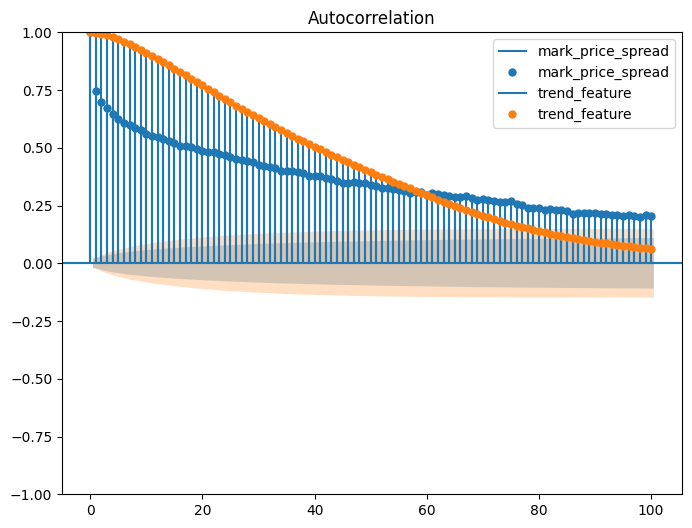

In [8]:
#Let’s now look at some of it’s statistical properties.
# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ACF of 'ob_imbalance_1' on the plot
sm.graphics.tsa.plot_acf(books['mark_price_spread'][-10000:], lags=100, ax=ax, label='mark_price_spread')
#sm.graphics.tsa.plot_acf(books['ob_imbalance_10'][-10000:], lags=100, ax=ax, label='ob_imbalance_2')
sm.graphics.tsa.plot_acf(books['trend_feature'][-10000:], lags=100, ax=ax, label='trend_feature')

# Add a legend to distinguish the plots
ax.legend()

# Show the plot
plt.show()

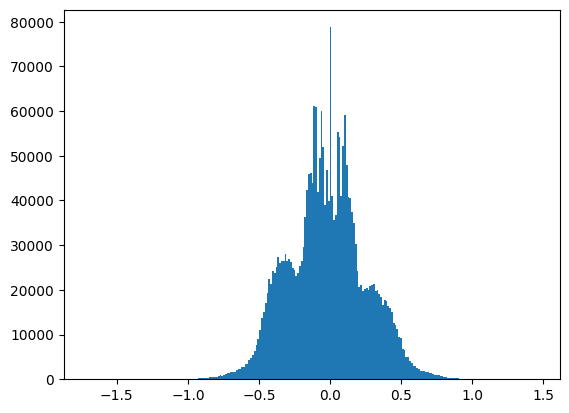

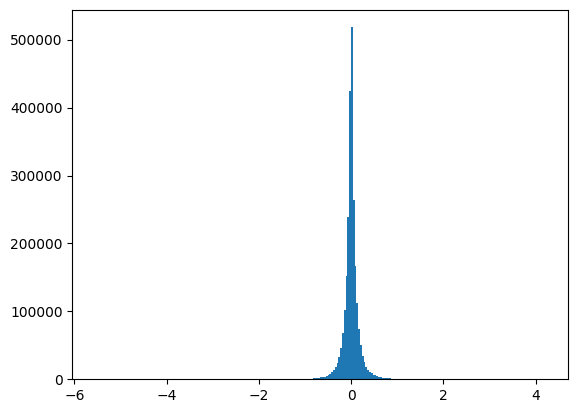

In [9]:
#Now let’s look at it’s distribution:
plt.hist([books['mark_price_spread'] *6], bins=250)
plt.show()

plt.hist([books['trend_feature']* 6], bins=250)
plt.show()

/var/folders/tk/17g1mb057qd17rjwhx9x88p40000gp/T/ipykernel_5051/1881447147.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  midprice_averages = df.groupby('b_imbalance_group')['midprice_change'].mean().values


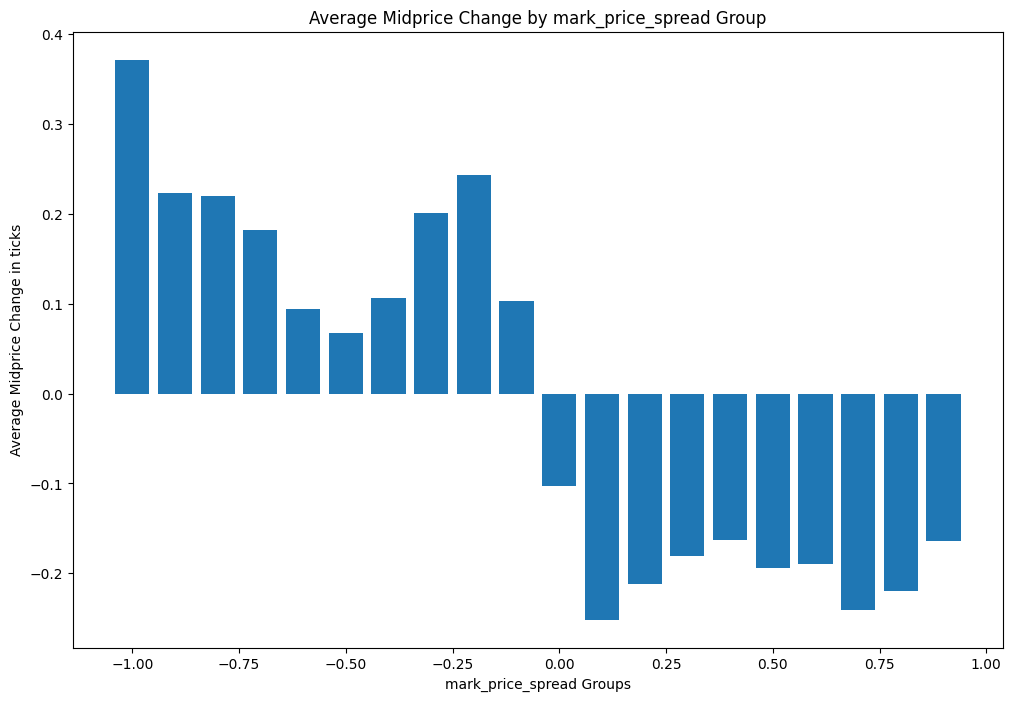

In [10]:
b_imbalance = np.array(books['mark_price_spread']*6)
midprices = np.array(books['mid'])
midprice_change = midprices[1:]-midprices[:-1]

#lets look at the avg midprice change for these vpin buckets
df = pd.DataFrame({'b_imbalance': b_imbalance[:-1], 'midprice_change': midprice_change / tick_size})

# Define the bins
bins = np.arange(-1, 1.1, 0.1)  # Adding 0.1 to include the upper bound
df['b_imbalance_group'] = pd.cut(df['b_imbalance'], bins=bins)
midprice_averages = df.groupby('b_imbalance_group')['midprice_change'].mean().values

# Your imbalance_groups remain the same
imbalance_groups = np.arange(-1, 1., 0.1)
# Plotting
plt.figure(figsize=(12, 8))
plt.bar(imbalance_groups, midprice_averages, width=0.08)  # Adjusted width to match new granularity
plt.xlabel('mark_price_spread Groups')
plt.ylabel('Average Midprice Change in ticks')
plt.title('Average Midprice Change by mark_price_spread Group')
plt.show()